**name: mahshad moradi** \
**std number: 400109373**



---

# Supervised Network training with the Forward-Forward algorithm

Libraries

In [ ]:
import torch
import torch.nn as nn
from tqdm import tqdm
from torch.optim import Adam
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, Normalize, Lambda
from torch.utils.data import DataLoader

 Load MNIST dataset

In [ ]:
def MNIST_loaders(train_batch_size=50000, test_batch_size=10000):
    """
    Provides PyTorch data loaders for the MNIST dataset.
    """
    transform = Compose([ToTensor(), Normalize((0.1307,), (0.3081,)), Lambda(lambda x: torch.flatten(x))])

    train_loader = DataLoader(MNIST('./data/', train=True, download=True, transform=transform), batch_size=train_batch_size, shuffle=True)

    test_loader = DataLoader(MNIST('./data/', train=False, download=True, transform=transform), batch_size=test_batch_size, shuffle=False)

    return train_loader, test_loader

Layer as a subb-class of torch.nn.Linear that uses the FF algorithm in the training of the layer

In [ ]:
class Layer(nn.Linear):

    def __init__(self, in_features, out_features, bias=True, device=None, dtype=None):
        super().__init__(in_features, out_features, bias, device, dtype)
        self.relu = torch.nn.ReLU()
        # Adam optimizer with a learning rate of 0.03
        self.opt = Adam(self.parameters(), lr=0.03)
        # Threshold for positive and negative samples
        self.threshold = 2.0
        self.num_epochs = 1000

    def forward(self, x):
        """
        Forward pass through the layer.
        """
        # normalizing the previous layer output
        x_direction = x / (x.norm(2, 1, keepdim=True) + 1e-4)
        # the relu output of the layer
        return self.relu(torch.mm(x_direction, self.weight.T) + self.bias.unsqueeze(0))

    def train(self, x_pos, x_neg):
        """
        Train the layer on positive and negative examples.
        """
        for i in tqdm(range(self.num_epochs)):
            # from the Goodness description
            g_pos = self.forward(x_pos).pow(2).mean(1)
            g_neg = self.forward(x_neg).pow(2).mean(1)
            # forwarding both the positive and negative data
            loss = torch.log(1 + torch.exp(torch.cat([self.threshold - g_pos , g_neg - self.threshold]))).mean()
            # optimization
            self.opt.zero_grad()
            loss.backward() #computing the derivatives
            self.opt.step()
        return self.forward(x_pos).detach(), self.forward(x_neg).detach()

The loss function $loss = mean(log(1 + exp[(threshold−positivedata),(negativedata−threshold)]))$ is designed to encourage positive samples to have values larger than the threshold and negative samples to have values smaller than the threshold as we wanted.

- **Positive Samples : the term $e^{(Threshold - PositiveData)}$:** This term encourages positive samples to have values larger than the threshold and amplifies their difference being exponential. If the model predicts a positive sample with a value significantly lower than the threshold, the loss will be high.

- **Negative Samples : the term $e^{(NegativeData - Threshold)}$:** This term encourages negative samples to have values smaller than the threshold and amplifies their difference being exponential. If the model predicts a negative sample with a value significantly higher than the threshold, the loss will be high.

**Overall Interpretation:** The loss function penalizes the model when it misplaces positive and negative samples relative to the specified threshold. It utilizes the logistic function and logarithm to provide a smooth and differentiable measure of how well the model is separating positive and negative samples around the threshold. The mean operation ensures that the loss is averaged across all samples, normalizing it for effective training of neural networks.


Network class with module attributes

In [ ]:
class Net(torch.nn.Module):

    def __init__(self, dims):
        super(Net, self).__init__()
        # constructing the network layers according to layer dimensions
        self.layers = []
        for d in range(len(dims) - 1):
            self.layers += [Layer(dims[d], dims[d + 1]).cuda()]

    def predict(self, x):
        """
        Make predictions using the trained network.
        """
        goodness_per_label = []
        # Iterate over labels
        for label in range(10):
            # h is the output of layers of the network
            layer_output = overlay_labels_on_data(x, label)
            goodness = []
            for layer in self.layers:
                # layer output and Goodness calculations
                layer_output = layer.forward(layer_output)
                goodness += [layer_output.pow(2).mean(1)]
            goodness_per_label += [sum(goodness).unsqueeze(1)]
        # Combine goodness values for each label
        goodness_per_label = torch.cat(goodness_per_label, 1)
        # Choose the label with the highest goodness
        return goodness_per_label.argmax(1)

    def train(self, x_pos, x_neg):
        """
        Train the network on positive and negative data.
        """
        h_pos, h_neg = x_pos, x_neg
        for i, layer in enumerate(self.layers):
            print('training layer', i)
            h_pos, h_neg = layer.train(h_pos, h_neg)

The method "predict" doeas the prediction of the test data as explained bellow for each sample of it :  
After training with FF, classifying a test digit involves a single forward pass through the network using an input comprising the test digit and a neutral label (ten entries of 0.1). The hidden activities in all layers except the first hidden layer are then used as inputs to a softmax learned during training. While this is a quick but sub-optimal method for image classification, a more effective approach is to run the network with a specific label as part of the input. The goodness values of all but the first hidden layer are accumulated for each label separately. Finally, the label with the highest accumulated goodness is chosen, providing a more informed and nuanced classification decision.

Data creation

In [ ]:
def overlay_labels_on_data(data_matrix, label_indices):
    """
    Replaces the first 10 pixels of each data sample with a one-hot-encoded label.
    """
    modified_data = data_matrix.clone()
    modified_data[:, :10].fill_(0.0)

    # Overlay one-hot-encoded labels on the data matrix
    modified_data[range(data_matrix.shape[0]), label_indices] = data_matrix.max()

    return modified_data

Creating the model and evaluating its results

In [ ]:
train_loader, test_loader = MNIST_loaders()

net = Net([784, 500, 500])
x, y = next(iter(train_loader))
x, y = x.cuda(), y.cuda()

# creating positive data
x_pos = overlay_labels_on_data(x, y)
rnd = torch.randperm(x.size(0))
# creating negative data using wrong lables
x_neg = overlay_labels_on_data(x, y[rnd])

# training the model
net.train(x_pos, x_neg)

training layer 0


100%|██████████| 1000/1000 [01:05<00:00, 15.32it/s]


training layer 1


100%|██████████| 1000/1000 [00:40<00:00, 24.44it/s]


The evaluation results

In [ ]:
print(' ')

train_accuracy = net.predict(x).eq(y).float().mean().item()
print('train accuracy :', train_accuracy)
print('train error:', 1.0 - train_accuracy)

# the test data
x_test, y_test = next(iter(test_loader))
x_test, y_test = x_test.cuda(), y_test.cuda()

test_accuracy = net.predict(x_test).eq(y_test).float().mean().item()
print('test accuracy :', train_accuracy)
print('test error:', 1.0 - test_accuracy )

 
train accuracy : 0.9275799989700317
train error: 0.07242000102996826
test accuracy : 0.9275799989700317
test error: 0.07160001993179321




---

# Unsupervised Network training with the Forward-Forward algorithm

Libraries

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from scipy.signal import convolve2d
from torch import tensor, Tensor
import torchvision
from tqdm import tqdm
import os
from sklearn.metrics import accuracy_score
from torch.optim import Adam
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, Normalize, Lambda
from torch.utils.data import DataLoader
import scipy.ndimage
import random
import torch.nn.functional as F

Negative data creation

In [ ]:
# for generating neg data using random samples of pos data
def make_random_pairs(length):
  tmp = np.random.randint(length, size=[length, 2])
  random_arr = [(row[0], row[1]) for row in tmp]
  return random_arr

def neg_data_loader(num=-1):
    transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

    # Load the train MNIST dataset
    train_dataset = torchvision.datasets.MNIST(root="./", train=True, transform=transform, download=True)

    if num == -1:
      num = len(train_dataset)
    # make random pairs of train dataset
    random_pairs = make_random_pairs(num)

    # Transform the data
    transformed_dataset = []
    for pair in random_pairs:
        image1 = train_dataset[pair[0]][0].squeeze()
        image2 = train_dataset[pair[1]][0].squeeze()
        mask = create_mask((image_1.shape[0], image_1.shape[1]))
        transformed_dataset.append(torch.add(torch.mul(image_1, mask), torch.mul(image_2, 1 - mask)).type(torch.float32))

    return transformed_dataset

# create mask for a given shape
def create_mask(shape):
    blur_filter_1 = np.array(((0, 0, 0), (1/4, 1/2, 1/4), (0, 0, 0)))
    blur_filter_2 = blur_filter_1.T

    # Create a random binary image
    image = np.random.randint(0, 2, size=shape)

    # Blur the image with the specified filter
    for i in range(10):
        image = np.abs(convolve2d(image, blur_filter_1, mode='same'))
        image = np.abs(convolve2d(image, blur_filter_2, mode='same'))

    # Binarize the blurred image
    mask = np.round(image).astype(np.uint8)

    return tensor(mask)

Sample of negative data creation using implemented mask as explained in the paper

100%|██████████| 9912422/9912422 [00:00<00:00, 136418469.40it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 37690010.52it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 124250218.22it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21167254.19it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



<ipython-input-3-78b63cb0ff54>:8: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  image_1 = torch.as_tensor(np.asarray(image_1))


<Figure size 640x480 with 0 Axes>

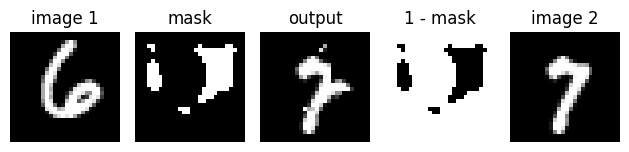

In [ ]:
# Load the MNIST dataset
mnist = torchvision.datasets.MNIST(root='data/', download=True)

# Get the first instance of the digit 1
image_1, _ = mnist[np.random.randint(len(mnist))]
image_2, _ = mnist[np.random.randint(len(mnist))]

image_1 = torch.as_tensor(np.asarray(image_1))
image_2 = torch.as_tensor(np.asarray(image_2))

mask = create_mask((28, 28))
image = torch.add(torch.mul(image_1, mask), torch.mul(image_2, 1 - mask))

plt.figure()

# Create the subplot
fig, ax = plt.subplots(1, 5)
images = [image_1, mask, image, 1 - mask, image_2]
names = ["image_1", "mask", "image", "1-mask", "image_2"]
# Add the images to the subplot
ax[0].imshow(image_1, cmap='gray')
ax[0].axis("off")
ax[0].set_title("image 1")
ax[1].imshow(mask, cmap='gray')
ax[1].axis("off")
ax[1].set_title("mask")
ax[2].imshow(image, cmap='gray')
ax[2].axis("off")
ax[2].set_title("output")
ax[3].imshow(1 - mask, cmap='gray')
ax[3].axis("off")
ax[3].set_title("1 - mask")
ax[4].imshow(image_2, cmap='gray')
ax[4].axis("off")
ax[4].set_title("image 2")

# Show the subplot
plt.tight_layout()
plt.show()

Negative data is generated by crafting a mask that includes substantial regions of ones and zeros. In the next step we create hybrid images for the negative dataset by combining one digit image with the mask and another digit image with the reverse of the mask, as depicted above as a sample. These masks are generated by initially using a random bit image and repeatedly applying blurring with a filter of [1/4, 1/2, 1/4] in both horizontal and vertical directions. After multiple blurring iterations, the image is then thresholded at 0.5.

In [14]:
# forward forward layer class which is linear
class FF_Layer(nn.Linear):
    def __init__(self, in_features, out_features, n_epochs, bias, device):
        super().__init__(in_features, out_features, bias=bias)
        self.n_epochs = n_epochs
        self.opt = torch.optim.Adam(self.parameters())
        self.to(device)
        self.ln_layer = nn.LayerNorm(normalized_shape=[1, out_features]).to(device)

    def forward(self, input):
        input = super().forward(input)
        input = self.ln_layer(input.detach())
        return input

    # learn the weights of this linear function
    def learn(self, pos_acts, neg_acts):
        self.opt.zero_grad()
        goodness = self.goodness_score(pos_acts, neg_acts)
        goodness.backward()
        self.opt.step()

    def goodness_score(self, pos_acts, neg_acts, threshold=2):
        """
        The goodness score is calculated by summing up the positive and negative goodness values.
        This score is the actual quantity that undergoes optimization, not the goodness values themselves.
        The goodness values, in essence, refer to the same underlying metric, but they do not include the subtraction of a threshold.
        In other words, the goodness score represents the combined impact of positive and negative factors, while the goodness values
        without the threshold subtraction provide a measure of the inherent quality without the influence of a specific threshold.
        """
        pos_goodness = -torch.sum(torch.pow(pos_acts, 2)) + threshold
        neg_goodness = torch.sum(torch.pow(neg_acts, 2)) - threshold
        return torch.add(pos_goodness, neg_goodness)

# main model
class UsNet(nn.Module):
    def __init__(self, n_epochs, n_layers=12, input_size = 28 * 28, n_neurons=2048,
                 bias = True, n_hid_to_log=3, n_classes=10, device = "cuda:0" if torch.cuda.is_available() else "cpu"):
        super().__init__()
        self.n_hid_to_log = n_hid_to_log
        self.n_epochs = n_epochs
        self.device = device
        self.ff_layers = [FF_Layer(in_features=input_size, out_features=n_neurons, n_epochs=n_epochs, bias=bias, device=device)]
        for idx in range(n_layers - 1):
          self.ff_layers.append(FF_Layer(in_features=n_neurons, out_features=n_neurons, n_epochs=n_epochs, bias=bias, device=device))
        self.last_layer = nn.Linear(in_features=n_neurons * n_hid_to_log, out_features=n_classes, bias=bias)
        self.softmax = nn.Softmax()
        self.to(device)
        self.opt = torch.optim.Adam(self.last_layer.parameters())

    def train_with_datasets(self, pos_dataloader, neg_dataloader):
        self.train()
        self.train_ff_layers(pos_dataloader, neg_dataloader)
        self.train_last_layer(pos_dataloader)


    def train_ff_layers(self, pos_dataloader, neg_dataloader):
        """
        train the ff layers separately
        it uses goodness score to classify pos and neg data
        """
        for epoch in tqdm(range(self.n_epochs), desc="FF Layers training", position=0):
            for (pos_imgs, _), neg_imgs in zip(pos_dataloader, neg_dataloader):
                pos_acts = torch.reshape(pos_imgs, (pos_imgs.shape[0], 1, -1)).to(self.device)
                neg_acts = torch.reshape(neg_imgs, (neg_imgs.shape[0], 1, -1)).to(self.device)
                for layer in self.ff_layers:
                    pos_acts = layer(pos_acts)
                    neg_acts = layer(neg_acts)
                    layer.learn(pos_acts, neg_acts)

    def train_last_layer(self, dataloader):
        """
        this function use supervised learning to label each data(which is positive data), it uses softmax function and then
        crossentropy loss for classifying the datas.
        """
        best_weights = self.state_dict()
        min_loss = float('inf')
        loss_module = torch.nn.CrossEntropyLoss(reduction="mean")
        for epoch in tqdm(range(self.n_epochs), desc="Last Layer training", position=0):
            epoch_loss = 0
            for images, labels in dataloader:
                images = images.to(self.device)
                labels = labels.to(self.device)
                self.opt.zero_grad()
                preds = self(images)
                loss = loss_module(preds, labels)
                epoch_loss += loss
                loss.backward()
                self.opt.step()
            if min_loss > epoch_loss:
                min_loss = epoch_loss
                best_weights = self.state_dict()
        self.load_state_dict(best_weights)

    def forward(self, image):
        image = image.to(self.device)
        image = torch.reshape(image, (image.shape[0], 1, -1))
        concat_output = []
        for idx, layer in enumerate(self.ff_layers):
            image = layer(image)
            if idx > len(self.ff_layers) - self.n_hid_to_log - 1:
                concat_output.append(image)
        concat_output = torch.concat(concat_output, 2)
        logits = self.last_layer(concat_output)
        return logits.squeeze()

    def evaluate(self, dataloader):
        """
        calculate the accuracy of the model on the given dataloader.
        """
        self.eval()
        correct = 0
        for images, labels in tqdm(dataloader, desc=f"Evaluating model", position=0):
            images = images.to(self.device)
            labels = labels.to(self.device)
            preds = self(images)
            preds = torch.argmax(preds, 1)
            preds = Tensor.numpy(preds, force=True)
            labels = Tensor.numpy(labels, force=True)
            correct += np.sum(preds == labels)
        acc = correct / len(dataloader.dataset)
        return acc

Initially, the system learns to transform input vectors into representation vectors without utilizing any information about the associated labels. In this phase, the focus is on capturing inherent patterns and structures within the data without explicit guidance from labeled examples.

Subsequently, the model learns a simple linear transformation (Linear classifier) of these representation vectors into vectors of logits. Logits are unnormalized values that serve as inputs to a softmax function. The softmax function then computes a probability distribution over labels based on these logits.

The combination of unsupervised learning for feature extraction and supervised learning for the linear transformation creates a comprehensive model capable of both capturing complex data representations and making informed predictions based on labeled information.

In [16]:
neg_dataset = neg_data_loader()

# Load the MNIST dataset
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
pos_dataset = torchvision.datasets.MNIST(root='./', download=True, transform=transform, train=True)

# Create the data loader
pos_dataloader = DataLoader(pos_dataset, batch_size=64, shuffle=True)

# Create the data loader
neg_dataloader = DataLoader(neg_dataset, batch_size=64, shuffle=True)

# Create the test data loader
test_dataloader = DataLoader(torchvision.datasets.MNIST(root='./', train=False, download=False, transform=transform),
                             batch_size=64, shuffle=True)

usNet = UsNet(n_epochs=10)

usNet.train_with_datasets(pos_dataloader, neg_dataloader)
train_acc = usNet.evaluate(pos_dataloader)
test_acc = usNet.evaluate(test_dataloader)


print(f"\ntrain dataset scores: \n accuracy: {train_acc * 100}%, error: {1 - train_acc}" )
print(f"test dataset scores: \n accuracy: {test_acc * 100}%, error: {1 - test_acc}" )

Evaluating model: 100%|██████████| 157/157 [00:01<00:00, 94.86it/s]


train dataset scores: 
 accuracy: 90.58666666666667%, error: 0.09413333333333329
test dataset scores: 
 accuracy: 90.07%, error: 0.09930000000000005
